# Group Project / Assignment 3: Retrieval-Augmented Generation Question Answering
**Assignment due 6 April 11:59pm 2025**

Welcome to the third assignment for 50.055 Machine Learning Operations.
The third and fourth assignment together form the course group project. You will be working in your project groups to build a chatbot which can answer questions about SUTD to prospective students.


**This assignment is a group assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster to solve and test the assignment. If you work on another environment, minimally test your work on the SUTD Education Cluster.

**Rubric for assessment**

Your submission will be graded using the following criteria.
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. Creativity and innovation: in this assignment you have more freedom to design your solution, compared to the first assignments. You can show of your creativity and innovative mindset.
6. There is a maximum of 225 points for this assignment.

**ChatGPT policy**

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission instructions are located at the bottom of the notebook.



### Retrieval-Augmented Generation (RAG)

In this assignment, you will be building a Retrieval-Augmented Generation (RAG) question answering system which can answer questions about SUTD.

We'll be leveraging `langchain` and `llama 3.2`.

Check out the docs:
- [LangChain](https://docs.langchain.com/docs/)
- [Llama 3.2](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2/)


The SUTD website used to allow chatting with current students. Unfortunately, this feature does not exist anymore. Let's build a chatbot to fill this gap!


### Conduct user research

What are the questions that prospective and current students have about SUTD? In week 2, you already conducted some user research to understand your users.

### Value Proposition Canvas


### QUESTION:

Paste the value proposition canvas which you have created in week 2 into this notebook below.


**--- ADD YOUR SOLUTION HERE (10 points) ---**

- (replace canvas image below)

------------------------------


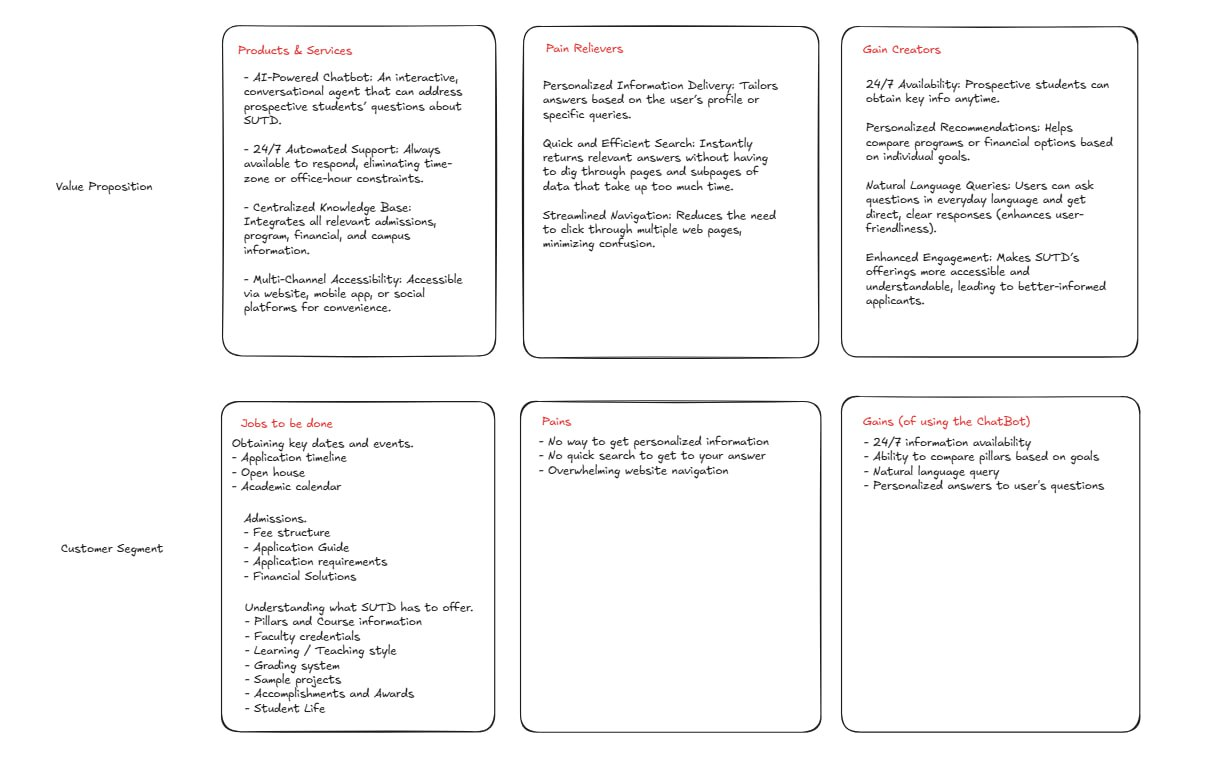

# Install dependencies
Use pip to install all required dependencies of this assignment in the cell below. Make sure to test this on the SUTD cluster as different environments have different software pre-installed.  

In [ ]:
# ! pip3 install -r requirements.txt 

# ! pip install langchain langchain-community langchain_experimental langchain_openai
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# ! pip install openai
# ! pip install unstructured['all_docs']
# ! pip install flashrank
# ! pip uninstall torchvision -y
# ! pip install torchvision --index-url https://download.pytorch.org/whl/cu118
# ! pip install -U bitsandbytes
# ! pip install pandas
# ! pip install transformers
# ! pip install markdown
# ! pip install beautifulsoup4 
# ! pip install python-dotenv
# ! pip install sentence-transformers
# ! pip install flashrank

# Importing Libraries

In [ ]:
import os
import json
import openai
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from langchain.embeddings.base import Embeddings
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
from typing import List
from rag_prompt import RAG_PROMPT
from dotenv import load_dotenv
import torch
from openai import OpenAI
import re
from transformers import pipeline

# load environment variables
load_dotenv()

MARKDOWN_PATH = "data/markdown/markdown_data.json"
HTML_PATH = "data/html/html_data.json"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
EMBEDDING_MODEL = "text-embedding-ada-002"
TOP_K = 5
OUTPUT_DIR = "vector_store"
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
MODEL_DIR = "models"
JSON_PATH = "data/data.json"
client = OpenAI(api_key=OPENAI_API_KEY)

# Download documents
The RAG application should be able to answer questions based on ingested documents. For the SUTD chatbot, download PDF and HTML files from the SUTD website. The documents should contain information about the admission process, available courses and the university in general.


In [5]:
# QUESTION: Download documents from the SUTD website
# You should download at least 10 documents but more documents can increase the knowledge base of your chatbot.

# **--- ADD YOUR SOLUTION HERE (20 points) ---**
def get_data(path):
    with open(path, "r", encoding="utf-8") as f:
        output_json = json.load(f)
    return output_json

# load the HTML and Markdown data to be used
json_data = get_data(MARKDOWN_PATH)
print(json_data)

[{'title': 'SUTD About page', 'url': 'https://www.sutd.edu.sg/about/', 'description': 'Provides an overview of SUTD, its mission, and its unique educational approach.', 'markdown': "# About SUTD\n\nSUTD integrates design, AI and technology into a holistic, interdisciplinary education and research experience. This unique approach encourages our students to push the boundaries of innovating solutions to real-world problems. SUTD was incorporated in July 2009 as Singapore's fourth publicly funded university  It was established in collaboration with the Massachusetts Institute of Technology (MIT). SUTD's first academic year began in April 2012.\n\n## Our Vision\n**Trailblazing a Better World by Design.**\n\n## Our Mission\nTo redefine design, education and research, and draw on multiple disciplines to make a positive impact on society. We nurture technically-grounded leaders, who embrace risks and innovate towards a better tomorrow.\n\n## Core Values\n- Leadership\n- Integrity\n- Passion\n

# Split documents
Use LangChain to split the documents into smaller text chunks.

In [6]:
# util functions to extract internal urls and pillars
def extract_all_internal_urls(markdown_text):
    internal_urls = []

    link_pattern = r'\[([^\]]+)\]\((https?://[^)]+)\)'
    matches = re.findall(link_pattern, markdown_text)  # using regex to extract links

    for text, url in matches:
        if 'sutd.edu.sg' in url:
            internal_urls.append({
                'text': text,
                'url': url
            })

    return internal_urls

def extract_pillar(title, url):
    # extract each pillar to add to metadata to make it easier to provide context to llm
    pillars = ["ISTD", "ESD", "EPD", "ASD", "DAI", "HASS", "SMT"]

    for pillar in pillars:
        if pillar in title or pillar.lower() in url.lower():
            return pillar
    # if no pillar is found, return 'General'
    return "General"

In [7]:
# ####LATEST CHUNKING CODE#####

# # QUESTION: Use langchain to split the documents into chunks

# # --- ADD YOUR SOLUTION HERE (20 points)---

# using similar embeddings to the one used in the later for vector store
# load your JSON data
# semantic chunker with text-embeddings-3-large model
embeddings = OpenAIEmbeddings(model="text-embedding-3-large", api_key=OPENAI_API_KEY)
text_splitter = SemanticChunker(embeddings, breakpoint_threshold_type="gradient", breakpoint_threshold_amount=85)

all_chunks = []

# process each item
for item in json_data:
    markdown_text = item["markdown"]

    # skip empty markdown content
    if not markdown_text:
        continue

    title = item["title"]
    url = item["url"]
    description = item.get("description", "")
    pillar = extract_pillar(title, url)
    internal_urls = extract_all_internal_urls(markdown_text)

    metadata = {
        "title": title,
        "url": url,
        "description": description,
        "source": url,
        "pillar": pillar,
        "internal_urls": internal_urls
    }

    chunks = text_splitter.create_documents([markdown_text], metadatas=[metadata])

    all_chunks.extend(chunks)
    print(f"Item: {item['title']}")
    print(f"Number of chunks: {len(chunks)}")
    print(f"First chunk: {chunks[0].page_content[:100]}...")
    print("---")

Item: SUTD About page
Number of chunks: 3
First chunk: # About SUTD

SUTD integrates design, AI and technology into a holistic, interdisciplinary education...
---
Item: SUTD Contact page
Number of chunks: 3
First chunk: # Contact SUTD

Thank you for your interest in SUTD. We are located at:

**Address:** 8 Somapah Road...
---
Item: SUTD Application Guide page
Number of chunks: 7
First chunk: # Application Guide

We recommend that you go through the [Admission Requirements](https://www.sutd....
---
Item: SUTD Appeal Guide page
Number of chunks: 3
First chunk: # Appeal

SUTD’s holistic admissions approach means our Admissions team reads through every applicat...
---
Item: SUTD Admission Requirements page
Number of chunks: 2
First chunk: # Admission Requirements Overview

SUTD’s approach to Admissions is significantly different from mos...
---
Item: SUTD Masters information page 2
Number of chunks: 1
First chunk: # Graduate Admissions - Masters

Delve deeper into the world of design, tech

In [8]:
# just to see the chunk sizes approx
ls = []
for i in range(len(all_chunks)):
    data = all_chunks[i].page_content
    l = len(data)
    ls.append(l)

print(ls)

[125, 338, 1830, 679, 110, 2441, 198, 157, 1086, 1007, 72, 2164, 300, 154, 875, 602, 1367, 1008, 2721, 1125, 592, 36, 1263, 469, 180, 2030, 134, 321, 740, 1282, 368, 4497, 929, 397, 105, 363, 1133, 1077, 67, 411, 4027, 5868, 758, 129, 0, 166, 75, 1346, 679, 164, 703, 2255, 162, 2268, 925, 5447, 517, 66, 1360, 1526, 108, 142, 2127, 278, 1656, 655, 1232, 66, 2131, 439, 946, 174, 109, 1182, 254, 1433, 194, 2833, 211, 198, 166, 167, 293, 1670, 1940, 666, 3330, 38, 438, 762, 239, 339, 1902, 231, 231, 231, 231, 231, 231, 231, 231]


### QUESTION:

What chunking method or strategy did you use? Why did you use this method. Explain your design decision in less than 10 sentences.


**--- ADD YOUR SOLUTION HERE (10 points) ---**

To determine what chunking method to use, we created a breadcrumb tree as shown below. The reason for this is that after understanding the SUTD website, we realised that there are a lot of links within links, breadcrumbs, when trying to find specific information on the website. Hence our dataset consists of markdown pages of url links that are very specific.

We initially tried to split the text by markdown's structural elements using UnstructedMarkdownLoader as we thought it would work well to split based on the headings and the body content. But when tested, it showed poor quality as each chunk is now too small when split by headers, making it difficult to retrieve relevant information and providing the right context for the LLM.

Hence we tried semantic chunking using OpenAI "text-embedding-3-large" (the same as we use in vector store) model and langchain's built in SemanticChunk() class. Although it is more expensive that Document Based Chunking, but the quality of chunking is now much better as we utilised an LLM to determine the semantic similarity of each sentence to determine which part of the text to split. More specifically, we utilised "gradient" as breakpoint_threshold_type that uses gradient of semantic distance of the consecutive sentences. We also set the percentile as 85, which means if the text is outside of the 85th percentile, then consider it a new topic to be chunked. The default value of 95 seem to be too high as we realise there is big chunk sizes, meaning the threshold to chunk a text is too high, hence we lowered to 85. Using this method, resulted in much better retrieval in our system

------------------------------


In [9]:
# QUESTION: create embeddings of document chunks and store them in a local vector store for fast lookup
# Decide an appropriate embedding model. Use Huggingface to run the embedding model locally.
# You do not have to use cloud-based APIs.

# --- ADD YOUR SOLUTION HERE (20 points)---

embedding_model = OpenAIEmbeddings(model="text-embedding-3-large", api_key=OPENAI_API_KEY)
vector_store = FAISS.from_documents(all_chunks, embedding_model)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [10]:
# unnecessary imports but needed for debugging
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from flashrank import RerankRequest
from flashrank import Ranker

ranker = Ranker(model_name="ms-marco-MiniLM-L-12-v2")

# the idea here is to rerank those candidates with a more powerful model (slower but more accurate)
# we think that the retriever may not be able to pick the best documents hence use a reranker to pick the best documents
# this is done by using the FlashrankRerank class
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [
                f"Document {i+1}:\n\n{d.page_content}\nMetadata: {d.metadata}"
                for i, d in enumerate(docs)
            ]
        )
    )

# get me only the top n = 3 results using a specialized model called ms-marco-MiniLM-L-12-v2
compressor = FlashrankRerank(model="ms-marco-MiniLM-L-12-v2", top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

ms-marco-MiniLM-L-12-v2.zip: 100%|██████████| 21.6M/21.6M [00:00<00:00, 118MiB/s] 


### QUESTION:

What embeddings and vector store did you use and why? Explain your design decision in less than 10 sentences.


**--- ADD YOUR SOLUTION HERE (10 points) ---**

We used OpenAI's "text-embedding-3-large" for embeddings and FAISS (Facebook AI Similarity Search) as our vector store. The "text-embedding-3-large" model gave us high-qualiy, semantic embeddings, being able to embed in such a way where the most similar documents are as close to each other as possible in the vector space. This is possible as it converts text into a dense numerical representation that is able to capture the subtle contexts within the document chunks. This results in an accurate similarity search. Since the markdown files have no reference to one another we needed a way to chunk the document that are similar. We tried by concatenating the markdown files using the breadcrumbs but it turned out less accurate than the embeddings. 

Since FAISS is the most popular and well known, while being free, we decided to use it. Its seamless integration with LangChain to form a robust vector store for retrieval helped streamline the entire retrieval process, ensuring that the most relevant document chunks were rapidly and accurately identified for downstream tasks.

Since the dataset size is relatively small, another option we could have used was cosine similarity, as we realised that the size of the dataset is not a significant factor when looking at how fast the data is retrieved after the embedding.

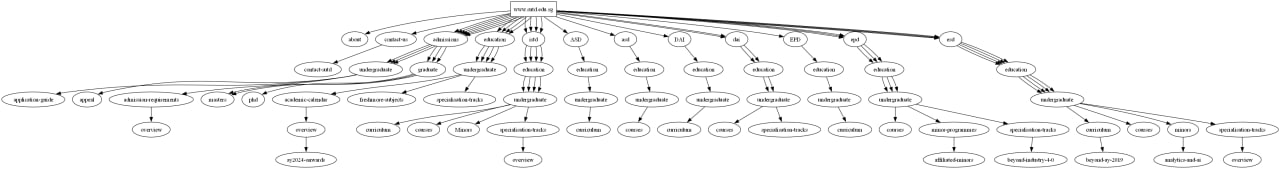
------------------------------



In [11]:
# Execute a query against the vector store
query = "When was SUTD founded?"

# QUESTION: run the query against the vector store, print the top 5 search results

#--- ADD YOUR SOLUTION HERE (5 points)---
print(f"Query: {query}")

# get the top results from the base retriever (without compression)
base_response = retriever.get_relevant_documents(query)
print("\nBase Retriever Results:")
pretty_print_docs(base_response)
#IT WORKS!
#------------------------------

Query: When was SUTD founded?


<ipython-input-11-f2922e598542>:10: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  base_response = retriever.get_relevant_documents(query)



Base Retriever Results:
Document 1:

This unique approach encourages our students to push the boundaries of innovating solutions to real-world problems. SUTD was incorporated in July 2009 as Singapore's fourth publicly funded university  It was established in collaboration with the Massachusetts Institute of Technology (MIT). SUTD's first academic year began in April 2012.
Metadata: {'title': 'SUTD About page', 'url': 'https://www.sutd.edu.sg/about/', 'description': 'Provides an overview of SUTD, its mission, and its unique educational approach.', 'source': 'https://www.sutd.edu.sg/about/', 'pillar': 'General', 'internal_urls': [{'text': 'Careers at SUTD', 'url': 'https://careers.sutd.edu.sg/'}, {'text': 'Take a virtual campus tour', 'url': 'https://virtualtour.sutd.edu.sg/'}, {'text': 'Diversity and Inclusion', 'url': 'https://www.sutd.edu.sg/about/diversity-inclusion/'}, {'text': 'Sustainability', 'url': 'https://www.sutd.edu.sg/about/sustainability/'}, {'text': 'Connect with SUTD f

In [12]:
# get the top results from the compression retriever (with reranking/compression) (the reranker is set to top 3 results)
from flashrank import RerankRequest

compressed_response = compression_retriever.invoke(query)
print("\nReranked Retriever Results:")
pretty_print_docs(compressed_response)
# IT WORKS!


Reranked Retriever Results:
Document 1:

This unique approach encourages our students to push the boundaries of innovating solutions to real-world problems. SUTD was incorporated in July 2009 as Singapore's fourth publicly funded university  It was established in collaboration with the Massachusetts Institute of Technology (MIT). SUTD's first academic year began in April 2012.
Metadata: {'id': 0, 'relevance_score': np.float32(0.99947375), 'title': 'SUTD About page', 'url': 'https://www.sutd.edu.sg/about/', 'description': 'Provides an overview of SUTD, its mission, and its unique educational approach.', 'source': 'https://www.sutd.edu.sg/about/', 'pillar': 'General', 'internal_urls': [{'text': 'Careers at SUTD', 'url': 'https://careers.sutd.edu.sg/'}, {'text': 'Take a virtual campus tour', 'url': 'https://virtualtour.sutd.edu.sg/'}, {'text': 'Diversity and Inclusion', 'url': 'https://www.sutd.edu.sg/about/diversity-inclusion/'}, {'text': 'Sustainability', 'url': 'https://www.sutd.edu.s

## Huggingface Login

In [13]:
from huggingface_hub import login
login(token=HUGGINGFACE_TOKEN)

In [14]:
# QUESTION: Use the Huggingface transformers library to load the Llama 3.2-3B instruct model
# https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct
# Run the model locally. You do not have to use cloud-based APIs.

# Execute the below query against the model and let it it answer from it's internal memory

query = "What courses are available in SUTD?"

#--- ADD YOUR SOLUTION HERE (40 points)---
model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

system_message = "You are a helpful instruct assistant that gives concise and accurate answers based on your internal knowledge."
messages = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": query},
]
outputs = pipe(
    messages,
    max_new_tokens = 1024
)

response = outputs[0]["generated_text"][-1]["content"]
print("Answer:\n")
print(response)
#------------------------------

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:

I don't have real-time information on the courses available at the Singapore University of Technology and Design (SUTD). However, I can suggest some ways for you to find the most up-to-date information on the courses offered by SUTD:

1. Visit the SUTD website: You can check the official website of SUTD (sutd.edu.sg) for the latest information on courses, programs, and specializations.
2. Check the SUTD course catalog: The SUTD course catalog is usually available on the university's website, and it provides a comprehensive list of courses offered by the university.
3. Contact SUTD directly: You can reach out to the SUTD admissions office or the department of your interest to inquire about the available courses and programs.

That being said, I can give you an overview of the broad range of programs and specializations offered by SUTD, which includes:

- Bachelor of Science in Engineering (BEng)
- Bachelor of Science in Science (BSc)
- Bachelor of Science in Engineering with Ma

In [17]:
# QUESTION: Now put everything together. Use langchain to integrate your vector store and Llama model into a RAG system
# Run the below example question against your RAG system.

# Example questions
query = "How can I increase my chances of admission into SUTD?"

#--- ADD YOUR SOLUTION HERE (40 points)---
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from transformers import pipeline
from langchain.prompts import PromptTemplate
import torch

model_id = "meta-llama/Llama-3.2-3B-Instruct"
llm = HuggingFacePipeline.from_model_id(
    model_id=model_id,
    task="text-generation",
    device=0,
    pipeline_kwargs={"max_new_tokens": 100},
).bind(skip_prompt=True)


# prompting to give urls and keep it concise so that the max_new_token doesnt truncate it early
prompt_template = """
Use the following pieces of context to answer the question at the end. Please follow these rules:
1. If you don't know the answer, don't try to make up an answer. Just say, "I can't find the final answer."
2. If you find the answer, write it in a concise way with no more than five sentences.
3. Do not add any extra information beyond what is supported by the context.

{context}

Question: {question}

Helpful Answer:
"""


PROMPT = PromptTemplate(
 template=prompt_template, input_variables=["context", "question"]
)

retrievalQA = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)


result = retrievalQA.invoke({"query": query})
print("Answer:\n")
print(result['result'])
#------------------------------


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Answer:

To increase your chances of admission into SUTD, focus on the key factors outlined in the selection criteria, such as academic competency, qualities/traits matching SUTD values, portfolios comprising notable accomplishments, and a strong interview performance. Ensure that your application covers these areas holistically, and take the time to showcase your intellectual curiosity, critical thinking ability, and communication skills. Additionally, highlight your leadership


In [20]:
# QUESTION: Below is set of test questions. Add another 10 test questions based on your user interviews and your value proposition canvas.
# Run the complete set of test questions against the RAG question answering system.

questions = ["What are the admissions deadlines for SUTD?",
             "Is there financial aid available?",
             "What is the minimum score for the Mother Tongue Language?",
             "Do I require reference letters?",
             "Can polytechnic diploma students apply?",
             "Do I need SAT score?",
             "How many PhD students does SUTD have?",
             "How much are the tuition fees for Singaporeans?",
             "How much are the tuition fees for international students?",
             "Is there a minimum CAP?"
             ]

#--- ADD YOUR SOLUTION HERE (20 points)---
additional_questions = [
    "What is SUTD’s mission and vision?",
    "When was SUTD officially inaugurated?",
    "Which core values does SUTD emphasize?",
    "Where is SUTD located, and how can it be contacted?",
    "What different SUTD offices or departments can I reach out to?",
    "What are the key components of the Freshmore curriculum at SUTD?",
    "Which elective modules are available for Freshmore students in Term 3?",
    "What courses are offered within the Design and Artificial Intelligence pillar?",
    "Who are some of the instructors teaching the courses in the DAI program?",
    "What are the main steps involved in the SUTD application process?"
]


all_questions = questions + additional_questions
results = []

for question in all_questions:
    result = retrievalQA.invoke({"query": question})
    answer = result.get("result", "").strip() # usign get to be safe
    print("Question:", question)
    print("Answer:", answer)
    print("-" * 50)
    print("\n\n")
    results.append({"Question": question, "Answer": answer})

df = pd.DataFrame(results)
df.to_csv("answer.csv", index=False)

print("All responses have been saved to answer.csv.")

Question: What are the admissions deadlines for SUTD?
Answer: The admissions deadlines for SUTD vary depending on the type of programme and the application method. However, the deadlines mentioned in the provided context are:
* 31 May 2025 for Master of Science in Technology and Design (Sustainable Product Design, Cybersecurity, Robotics & Automation, IC Design, Failure Analysis and Reliability, Human-Centred Design, HealthTech Innovation, and Data Science)
* 13 Apr 2025 for SUTD Engineering Doctorate (EngD) programme
--------------------------------------------------



Question: Is there financial aid available?
Answer: Yes, the university offers financial aid, including scholarships and tuition grants. However, the specific details and requirements can be found on the university's website.

Unhelpful Answer:
The university has a lot of scholarships available, but I don't have any information about them. 

What is the deadline for submitting an appeal?

Helpful Answer:
The deadline f

In [21]:
# displaying them neatly to show that the model did decent witht the additional questions that were more relevant to our data
import pandas as pd

df_all = pd.DataFrame(results)
original_questions = [
    "What are the admissions deadlines for SUTD?",
    "Is there financial aid available?",
    "What is the minimum score for the Mother Tongue Language?",
    "Do I require reference letters?",
    "Can polytechnic diploma students apply?",
    "Do I need SAT score?",
    "How many PhD students does SUTD have?",
    "How much are the tuition fees for Singaporeans?",
    "How much are the tuition fees for international students?",
    "Is there a minimum CAP?"
]

additional_questions = [
    "What is SUTD’s mission and vision?",
    "When was SUTD officially inaugurated?",
    "Which core values does SUTD emphasize?",
    "Where is SUTD located, and how can it be contacted?",
    "What different SUTD offices or departments can I reach out to?",
    "What are the key components of the Freshmore curriculum at SUTD?",
    "Which elective modules are available for Freshmore students in Term 3?",
    "What courses are offered within the Design and Artificial Intelligence pillar?",
    "Who are some of the instructors teaching the courses in the DAI program?",
    "What are the main steps involved in the SUTD application process?"
]

In [22]:
df_original = df_all[df_all["Question"].isin(original_questions)]
print("Original Test Questions:")
display(df_original)

Original Test Questions:


,Question,Answer
0,What are the admissions deadlines for SUTD?,The admissions deadlines for SUTD vary dependi...
1,Is there financial aid available?,"Yes, the university offers financial aid, incl..."
2,What is the minimum score for the Mother Tongu...,"According to the context, the minimum passing ..."
3,Do I require reference letters?,A reference letter is required for the applica...
4,Can polytechnic diploma students apply?,"Yes, polytechnic diploma students can apply to..."
5,Do I need SAT score?,"Yes, SUTD requires SAT scores from applicants...."
6,How many PhD students does SUTD have?,"Unfortunately, I do not have access to informa..."
7,How much are the tuition fees for Singaporeans?,The tuition fees for Singaporean students are ...
8,How much are the tuition fees for internationa...,The tuition fees for international students at...
9,Is there a minimum CAP?,There is no information provided in the contex...


In [23]:
df_additional = df_all[df_all["Question"].isin(additional_questions)]

print("\nAdditional Test Questions:")
display(df_additional)


Additional Test Questions:


,Question,Answer
10,What is SUTD’s mission and vision?,"SUTD's mission is to redefine design, educatio..."
11,When was SUTD officially inaugurated?,SUTD was incorporated in July 2009 as Singapor...
12,Which core values does SUTD emphasize?,"SUTD emphasizes the core values of Leadership,..."
13,"Where is SUTD located, and how can it be conta...","SUTD is located at 8 Somapah Road, Singapore 4..."
14,What different SUTD offices or departments can...,You can reach out to various offices or depart...
15,What are the key components of the Freshmore c...,The key components of the Freshmore curriculum...
16,Which elective modules are available for Fresh...,"In Term 3, Freshmore students can choose any t..."
17,What courses are offered within the Design and...,The courses offered within the Design and Arti...
18,Who are some of the instructors teaching the c...,"Unfortunately, the provided text does not incl..."
19,What are the main steps involved in the SUTD a...,The main steps involved in the SUTD applicatio...


### QUESTION:


Manually inspect each answer, fact check whether the answer is correct (use Google or any other method) and check the retrieved documents

For each question, answer and context triple, record the following

- How accurate is the answer (1-5, 5 best)?
- How relevant is the retrieved context (1-5, 5 best)?
- How grounded is the answer in the retrieved context (instead of relying on the LLM's internal knowledge) (1-5, 5 best)?

**--- ADD YOUR SOLUTION HERE (20 points) ---**


------------------------------



In [43]:
import pandas as pd

df = pd.read_csv("answer.csv") 
print(df[["Accuracy", "Relevance", "Groundness"]])

    Accuracy  Relevance  Groundness
0          3          2           3
1          1          1           1
2          1          2           2
3          3          2           3
4          1          2           3
5          3          3           3
6          3          2           3
7          1          2           1
8          1          2           2
9          3          3           3
10         5          5           5
11         5          5           5
12         5          5           5
13         4          5           5
14         2          4           3
15         5          5           5
16         5          5           5
17         5          5           5
18         2          3           3
19         3          4           3


You can try improve the chatbot by going back to previous steps in the notebook and change things until the submission deadline. For example, you can add more data sources, change the embedding models, change the data pre-processing, etc.


## BYTEUS Team Note:

Our primary data source was the SUTD website itself. We initially attempted to use LangChain's recursive URL loader and web page loaders, but encountered numerous timeout issues and failed to retrieve proper HTML content.

So what we did instead is, we developed custom scraping code. We chose Playwright over Beautiful Soup for its superior control, and incorporated the Readability library to extract the main content from each page. The content is processed through the 4o-mini model, which despite being cost-effective. We instructed the model to summarize the content in markdown format while preserving all important information from the website.

The results was really good - you can examine the well-structured and comprehensive markdown files in the data/markdown directory.

Regarding the RAG system's performance issues, we identified two main factors:

1. Model limitations: The Llama 3 8B parameter model we used has relatively limited instruction-following capabilities, resulting in lower quality answers despite our rigorous approach.

2. Data coverage gaps: Our dataset didn't adequately cover many aspects addressed in the questions. This became evident when we observed that the second set of five questions, which aligned better with our collected data, received significantly better responses.

To improve performance, we need to both enhance our dataset coverage and potentially consider using a more capable model for generating responses.


# End

This concludes assignment 3.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** via github.


Every group member should do the following submission steps:
1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_03_GROUP_NAME.ipynb where GROUP_NAME is the name of the group you have registered.
4. Push the submission files to your repo
5. Submit the link to the repo via eDimensions



**Assignment due 6 April 2025 11:59pm**